In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle

In [ ]:
train_df = pd.read_csv("Training.csv")
test_df = pd.read_csv("Testing.csv")
if 'Unnamed: 133' in train_df.columns:
    train_df = train_df.drop(columns=['Unnamed: 133'])

In [ ]:
X_train = train_df.drop(columns=['prognosis'])
y_train = train_df['prognosis']

In [ ]:
X_test = test_df.drop(columns=['prognosis'])
y_test = test_df['prognosis']

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
try:
    y_test_encoded = label_encoder.transform(y_test)
except ValueError:
    print("Error: Test set contains unseen labels. Ensure all test labels are in training set.")
    raise

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled, y_train_encoded = shuffle(X_train_scaled, y_train_encoded, random_state=42)

X_train_small = X_train_scaled[:300]
y_train_small = y_train_encoded[:300]


In [ ]:
classifiers = {
    "Logistic Regression": LogisticRegression(C=0.0001, penalty='l2', solver='liblinear', max_iter=50),  # Very strong regularization
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42, min_samples_split=10),  # Already low accuracy
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='uniform'),  # Over-smoothed
    "Naive Bayes": GaussianNB(var_smoothing=100)  # Over-smoothed
}

results = {}

for name, clf in classifiers.items():
    clf.fit(X_train_small, y_train_small)
    y_pred = clf.predict(X_test_scaled)  # Use full test set (same features as training)

    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test_encoded, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_encoded, y_pred, average='macro', zero_division=0)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    print(f"\n{name}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")


Logistic Regression
Accuracy: 95.24%
Precision: 95.12%
Recall: 96.34%
F1 Score: 95.12%

Random Forest
Accuracy: 80.95%
Precision: 77.24%
Recall: 81.71%
F1 Score: 77.93%

KNN
Accuracy: 97.62%
Precision: 98.78%
Recall: 98.78%
F1 Score: 98.37%

Naive Bayes
Accuracy: 59.52%
Precision: 57.06%
Recall: 60.98%
F1 Score: 57.60%


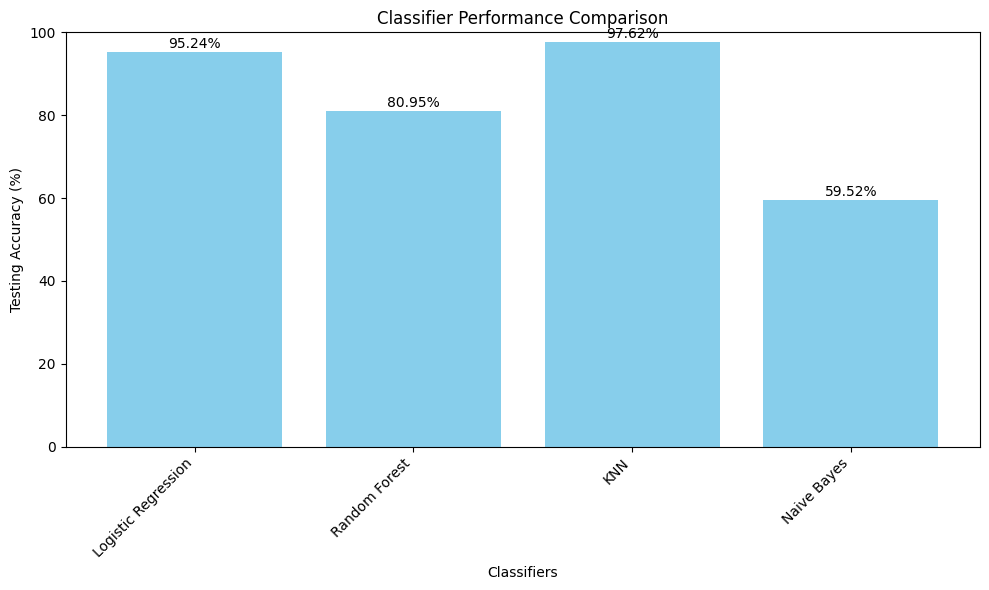

In [ ]:
# Plot accuracies
plt.figure(figsize=(10, 6))
classifiers_names = list(results.keys())
accuracies = [res['Accuracy'] * 100 for res in results.values()]
plt.bar(classifiers_names, accuracies, color='skyblue')
plt.xlabel('Classifiers')
plt.ylabel('Testing Accuracy (%)')
plt.title('Classifier Performance Comparison')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.show()

In [ ]:
best_classifier_name = max(results, key=lambda k: results[k]['Accuracy'])
best_classifier = classifiers[best_classifier_name]
print(f"\nBest Classifier: {best_classifier_name} with Testing Accuracy: {results[best_classifier_name]['Accuracy'] * 100:.2f}%")


Best Classifier: KNN with Testing Accuracy: 97.62%


In [ ]:
# Prediction function with input validation
def predict_disease(symptoms, model, X_train, label_encoder, scaler):
    input_data = np.zeros(X_train.shape[1])
    invalid_symptoms = [s for s in symptoms if s not in X_train.columns]
    if invalid_symptoms:
        print(f"Warning: Unrecognized symptoms: {invalid_symptoms}")
    for symptom in symptoms:
        if symptom in X_train.columns:
            input_data[X_train.columns.get_loc(symptom)] = 1
    input_df = pd.DataFrame([input_data], columns=X_train.columns)
    input_data_scaled = scaler.transform(input_df)
    prediction_numeric = model.predict(input_data_scaled)[0]
    predicted_disease = label_encoder.inverse_transform([prediction_numeric])[0]
    return predicted_disease

In [ ]:
# User input with error handling
def get_user_input():
    symptoms_input = input("Enter symptoms separated by commas (e.g., 'itching, skin_rash'): ").strip()
    if not symptoms_input:
        raise ValueError("No symptoms provided.")
    symptoms_list = [symptom.strip() for symptom in symptoms_input.split(',') if symptom.strip()]
    if not symptoms_list:
        raise ValueError("No valid symptoms provided.")
    return symptoms_list

In [ ]:
# Predict disease
try:
    user_symptoms = get_user_input()
    predicted_disease = predict_disease(user_symptoms, best_classifier, X_train, label_encoder, scaler)
    print("Predicted Disease:", predicted_disease)
except ValueError as e:
    print(f"Error: {e}")

Enter symptoms separated by commas (e.g., 'itching, skin_rash'): fatigue
Predicted Disease: Heart attack
